In [119]:
import os
import numpy as np
from PIL import Image

## load data

In [127]:
def load_data(data_path):
    img_names = [data_path + img_name for img_name in os.listdir(data_path)]
    img_array, img_label = list(), list()
    for img_name in img_names:
        img = np.array(Image.open(img_name))
        label = int(img_name.split('/')[-1].split('_')[0])
        img_array.append(img)
        img_label.append(label - 1)
    img_array, img_label = np.array(img_array), np.array(img_label)
    return img_array, img_label

## load training data

In [128]:
train_path = './Q2/Training/'
train_imgs, train_labels = load_data(train_path)
print('Total Training Images : ', train_imgs.shape[0])
print('Training Image Shape  : ', train_imgs[0].shape)

Total Training Images :  5933
Training Image Shape  :  (128, 64, 3)


## load Gallery data

In [130]:
gallery_path = './Q2/Testing/Gallery/'
gallery_imgs, gallery_label = load_data(gallery_path)
print('Total Gallery Images : ', gallery_imgs.shape[0])
print('Gallery Image Shape  : ', gallery_imgs[0].shape)

Total Gallery Images :  301
Gallery Image Shape  :  (128, 64, 3)


## load Probe data

In [131]:
probe_path = './Q2/Testing/Probe/'
probe_imgs, probe_label = load_data(probe_path)
print('Total Probe Images : ', probe_imgs.shape[0])
print('Probe Image Shape  : ', probe_imgs[0].shape)

Total Probe Images :  301
Probe Image Shape  :  (128, 64, 3)


## shuffle data

In [132]:
def shuffle_data(x, y):
    idx = list(range(x.shape[0]))
    np.random.shuffle(idx)
    return x[idx], y[idx]

## Nearest Neighborhood

#### get topk nearest neighborhood of each query image
#### treat gallery images as query images and probe images as target images

In [180]:
def l2_dist(x1, x2):
    diff = np.expand_dims(x1, axis=1) - np.expand_dims(x2, axis=0)
    if len(x1.shape) == 4:
        dist = np.sum(np.square(diff), axis=(2, 3, 4))
    else:
        dist = np.sum(np.square(diff), axis=2)
    return dist

In [187]:
gallery_probe_dist = l2_dist(gallery_imgs, probe_imgs)
print('Eculidian Distance : ', gallery_probe_dist.shape)

Eculidian Distance :  (301, 301)


### get topk nearest distance and corresponding index

In [152]:
import torch
import matplotlib.pyplot as plt

In [153]:
def get_topk(eculid_dist, k):
    dist_tensor = torch.from_numpy(eculid_dist.astype(np.float))
    value, idx = torch.topk(dist_tensor, dim=1, k=k, largest=False)
    return value.numpy(), idx.numpy()

In [154]:
rank = 50
min_dist, min_idx = get_topk(gallery_probe_dist, k=rank)
print('Top k label shape : ', min_idx.shape)

Top k label shape :  (301, 50)


### calculate cmc

In [155]:
def get_cmc(min_idx, gt_train, gt_test):
    add_acc = list()
    predict_label = np.zeros(min_idx.shape)
    for i in range(min_idx.shape[0]):
        predict_label[i, :] = gt_train[min_idx[i]]
    acc_count = np.zeros(predict_label.shape)
    for j in range(predict_label.shape[1]):
        acc_count[:, j] = np.equal(predict_label[:, j].astype(int), gt_test.astype(int)).astype('float')
        acc = np.sum(acc_count[:, 0: j + 1], axis=1)
        acc[acc > 1] = 1
        add_acc.append(np.mean(acc))
    return add_acc

In [160]:
cmc = get_cmc(min_idx, probe_label, gallery_label)
top1, top5, top10 = cmc[0], cmc[4], cmc[9]
print('Top-1  Acc : %.4f' % top1)
print('Top-5  Acc : %.4f' % top5)
print('Top-10 Acc : %.4f' % top10)

Top-1  Acc : 0.0997
Top-5  Acc : 0.1395
Top-10 Acc : 0.1794


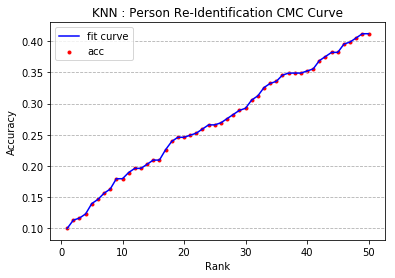

In [161]:
plt.plot(range(1, len(cmc) + 1), cmc, c='b')
plt.scatter(range(1, len(cmc) + 1), cmc, marker='.', c='r')
plt.legend([ 'fit curve', 'acc'])
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.grid(axis='y', ls='--')
plt.title('KNN : Person Re-Identification CMC Curve')
plt.show()

## Deep Neural Network

####  train a deep convolutional neural networks to classify training images, and then, extracting the feature map as image representations.

In [195]:
! pip install tensorflow==1.14.0

  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0


You should consider upgrading via the 'd:\anaconda\python.exe -m pip install --upgrade pip' command.


In [166]:
import tensorflow as tf
from resnet import resnet_v1
from tensorflow.keras.utils import to_categorical

In [169]:
model = resnet_v1(input_shape=(128, 64, 3), depth=20, num_classes=300)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 128, 64, 16)  448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 128, 64, 16)  64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 128, 64, 16)  0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

In [170]:
# pre-processing training data
x = train_imgs / 127.5 - 1.0
y = to_categorical(train_labels, 300)

In [171]:
model.fit(x, y, batch_size=12, epochs=20, verbose=1, shuffle=True)
model.save('./resnet.h5')

Epoch 1/20
5933/5933 [==============================] - 462s 78ms/sample - loss: 5.3440 - acc: 0.0863
Epoch 2/20
5933/5933 [==============================] - 458s 77ms/sample - loss: 2.7811 - acc: 0.3865
Epoch 3/20
5933/5933 [==============================] - 458s 77ms/sample - loss: 1.6248 - acc: 0.6110
Epoch 4/20
5933/5933 [==============================] - 460s 78ms/sample - loss: 1.0904 - acc: 0.7389
Epoch 5/20
5933/5933 [==============================] - 459s 77ms/sample - loss: 0.7867 - acc: 0.8138
Epoch 6/20
5933/5933 [==============================] - 457s 77ms/sample - loss: 0.6041 - acc: 0.8613
Epoch 7/20
5933/5933 [==============================] - 458s 77ms/sample - loss: 0.5078 - acc: 0.8958
Epoch 8/20
5933/5933 [==============================] - 458s 77ms/sample - loss: 0.4533 - acc: 0.9061
Epoch 9/20
5933/5933 [==============================] - 457s 77ms/sample - loss: 0.3791 - acc: 0.9321
Epoch 10/20
5933/5933 [==============================] - 455s 77ms/sample - loss: 

### feature extraction

#### extract the flattened last feature map as image representations

In [172]:
from tensorflow.keras.models import Model

In [173]:
def feature_extractor(resnet_model):
    inputs = resnet_model.input
    outputs = resnet_model.get_layer(name='flatten_2').output
    extractor = Model(inputs=inputs, outputs=outputs)
    return extractor

In [177]:
extractor = feature_extractor(model)
extractor.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 128, 64, 16)  448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 128, 64, 16)  64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 128, 64, 16)  0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

#### extract features of Gallery images and Probe features

In [178]:
gallery_features = extractor.predict(gallery_imgs / 127.5 - 1.0)
probe_features = extractor.predict(probe_imgs / 127.5 - 1.0)
print('Gallery features shape : ', gallery_features.shape)
print('Probe features shape : ', probe_features.shape)

Gallery features shape :  (301, 512)
Probe features shape :  (301, 512)


#### calculate L2_distance between gallery features and probe features

In [181]:
gallery_probe_feature_dist = l2_dist(gallery_features, probe_features)
print('Eculidian Distance between Extracted Features: ', gallery_probe_feature_dist.shape)

Eculidian Distance between Extracted Features:  (301, 301)


#### calculate topk match pairs

In [192]:
rank = 80
min_dist, min_idx = get_topk(gallery_probe_feature_dist, k=rank)
print('Top k label shape : ', min_idx.shape)

Top k label shape :  (301, 80)


#### calculate CMC

In [193]:
cmc = get_cmc(min_idx, probe_label, gallery_label)
top1, top5, top10 = cmc[0], cmc[4], cmc[9]
print('Top-1  Acc : %.4f' % top1)
print('Top-5  Acc : %.4f' % top5)
print('Top-10 Acc : %.4f' % top10)

Top-1  Acc : 0.3156
Top-5  Acc : 0.5216
Top-10 Acc : 0.6213


#### draw CMC Curve

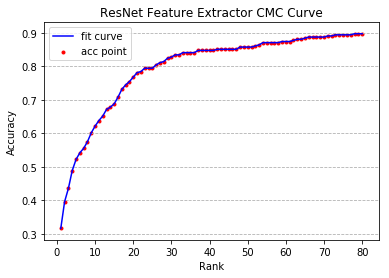

In [194]:
plt.plot(range(1, len(cmc) + 1), cmc, c='b')
plt.scatter(range(1, len(cmc) + 1), cmc, marker='.', c='r')
plt.legend([ 'fit curve', 'acc point'])
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.grid(axis='y', ls='--')
plt.title('ResNet Feature Extractor CMC Curve')
plt.show()

## Comparision of deep and non-deep methods

#### Strengths  : Deep CNN can achieve higher accuracy compared with the non-deep methods.
#### Weakness : The training of CNN is expensive and time-cost compared with the non-deep methods.